## Task 1 - Multi Layer Perceptron and other ML algos for Iris and Wine ds

In [2]:
import numpy as np
from sklearn.datasets import load_iris, load_wine
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Function to load and preprocess dataset
def prepare_dataset(loader_function):
    """
    Load and preprocess dataset.
    """
    data = loader_function()
    X = data.data
    y = data.target
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Load and preprocess datasets
X_train_iris, X_test_iris, y_train_iris, y_test_iris = prepare_dataset(load_iris)
X_train_wine, X_test_wine, y_train_wine, y_test_wine = prepare_dataset(load_wine)

In [4]:
# Custom MLP class for PyTorch
class CustomMLP(nn.Module):
    """
    Custom Multilayer Perceptron (MLP) model in PyTorch.
    """
    def __init__(self, input_size, hidden_sizes, output_size):
        super(CustomMLP, self).__init__()
        layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU()]
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [5]:
# Function to train and evaluate PyTorch MLP
def train_eval_pytorch_mlp(X_train, y_train, X_test, y_test, input_size, hidden_sizes, output_size):
    """
    Function to train and evaluate the PyTorch MLP model.
    """
    # Convert data to PyTorch tensors
    X_train, X_test, y_train, y_test = map(torch.tensor, (X_train, X_test, y_train, y_test))
    train_ds = TensorDataset(X_train.float(), y_train.long())
    train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

    # Initialize Model, Loss Function, Optimizer
    model = CustomMLP(input_size, hidden_sizes, output_size)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train Model
    model.train()
    for epoch in range(100):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_function(pred, yb)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    # Evaluate Model
    model.eval()
    with torch.no_grad():
        predictions = model(X_test.float())
        _, predicted = torch.max(predictions, 1)
        accuracy = (predicted == y_test).float().mean()
        report = classification_report(y_test.numpy(), predicted.numpy())
    return accuracy.item(), report

In [6]:
# Define hidden layer sizes for MLP
hidden_sizes = [100, 50]

# Train and evaluate MLP on Iris
mlp_accuracy_iris, mlp_report_iris = train_eval_pytorch_mlp(
    X_train_iris, y_train_iris, X_test_iris, y_test_iris,
    input_size=4, hidden_sizes=hidden_sizes, output_size=3
)

# Train and evaluate Random Forest on Iris
rf_iris = RandomForestClassifier(n_estimators=100, random_state=42)
rf_iris.fit(X_train_iris, y_train_iris)
rf_accuracy_iris = rf_iris.score(X_test_iris, y_test_iris)
rf_report_iris = classification_report(y_test_iris, rf_iris.predict(X_test_iris))

# Train and evaluate MLP on Wine
mlp_accuracy_wine, mlp_report_wine = train_eval_pytorch_mlp(
    X_train_wine, y_train_wine, X_test_wine, y_test_wine,
    input_size=13, hidden_sizes=hidden_sizes, output_size=3
)

# Train and evaluate Random Forest on Wine
rf_wine = RandomForestClassifier(n_estimators=100, random_state=42)
rf_wine.fit(X_train_wine, y_train_wine)
rf_accuracy_wine = rf_wine.score(X_test_wine, y_test_wine)
rf_report_wine = classification_report(y_test_wine, rf_wine.predict(X_test_wine))

In [7]:
# Print MLP accuracies and classification reports
print(f"MLP Accuracy on Iris: {mlp_accuracy_iris:.2f}")
print(mlp_report_iris)
print(f"MLP Accuracy on Wine: {mlp_accuracy_wine:.2f}")
print(mlp_report_wine)

# SVM Model Training and Evaluation
svm_parameters = {
    'kernel': ('linear', 'rbf'),
    'C': [1, 10]
}

# Train and evaluate SVM on Iris
svm_iris = GridSearchCV(SVC(), svm_parameters, cv=5)
svm_iris.fit(X_train_iris, y_train_iris)
svm_accuracy_iris = svm_iris.score(X_test_iris, y_test_iris)
svm_report_iris = classification_report(y_test_iris, svm_iris.predict(X_test_iris))

# Train and evaluate SVM on Wine
svm_wine = GridSearchCV(SVC(), svm_parameters, cv=5)
svm_wine.fit(X_train_wine, y_train_wine)
svm_accuracy_wine = svm_wine.score(X_test_wine, y_test_wine)
svm_report_wine = classification_report(y_test_wine, svm_wine.predict(X_test_wine))

# Print SVM accuracies and classification reports
print(f"SVM Accuracy on Iris: {svm_accuracy_iris:.2f}")
print(svm_report_iris)
print(f"SVM Accuracy on Wine: {svm_accuracy_wine:.2f}")
print(svm_report_wine)

# Print Random Forest accuracies and classification reports
print(f"Random Forest Accuracy on Iris: {rf_accuracy_iris:.2f}")
print(rf_report_iris)
print(f"Random Forest Accuracy on Wine: {rf_accuracy_wine:.2f}")
print(rf_report_wine)


MLP Accuracy on Iris: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

MLP Accuracy on Wine: 0.98
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.95      0.98        21
           2       0.93      1.00      0.97        14

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54

SVM Accuracy on Iris: 0.98
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.92      0.96     

## Task 2 - Classification of MNIST, FashionMNIST and CIFAR10 with a CNN

In [8]:
# Imports
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

In [9]:
# Check if CUDA or MPS available, otherwise CPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [10]:
# Setting batch and input size
batch_size = 250
input_size = 32

In [11]:
# Define datasets
# NOTE: this code will only work with datasets that have 10 classes!
data = [MNIST, FashionMNIST, CIFAR10]

In [12]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(train_features.size()[1], 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 3)
        #drop out 
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = self.dropout1(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [13]:
# Train the model
def train_model(model, train_loader, loss_function, optimizer, epochs = 3):
    model.train()
    epoch_losses = []
    for epoch in tqdm(range(epochs), desc = "Training Epochs"):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss)

In [14]:
# Test the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()
    accuracy = correct / len(test_loader.dataset)
    return accuracy

In [15]:
def display_prediction(model, data, rows=1, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    
    for ax in axes.flatten():
        rand_index = np.random.randint(0, len(data))
        image, label = data[rand_index]

        if train_features.size()[1] == 3:
            
            # Unnormalize the image
            image = image.numpy().transpose((1, 2, 0))
            mean = np.array([0.5, 0.5, 0.5])
            std = np.array([0.5, 0.5, 0.5])
            image = std * image + mean
            image = np.clip(image, 0, 1)
            ax.imshow(image)
            ax.set_title(f"Original Label: {labels_map[label]}")

            # Prepare the image for the model and ensure it is of the correct data type
            image = transforms.ToTensor()(image).float()  # Convert to float
            image = torch.unsqueeze(image, 0)
        else:
            ax.imshow(image.squeeze(), cmap="gray")
            ax.set_title(f"Original Label: {labels_map[label]}")
            image = image.unsqueeze(0)

        prediction = model(image)
        _, prediction_label = torch.max(prediction, 1)
        plt.title(f"Original Label: {labels_map[label]}")
        ax.set_xlabel(f"Predicted Label: {labels_map[prediction_label.item()]}")

    plt.tight_layout()
    plt.show()

In [16]:
# Folder to download the datasets
loc = r'C:/Users/ahidv/OneDrive/Desktop/datasets_improv2/'

In [17]:
# Params expanded   
epoch_list = [1,3,5]
lr_list = [0.01, 0.005, 0.001]

Starting with dataset MNIST!
Feature batch shape: torch.Size([250, 1, 32, 32])
Labels batch shape: torch.Size([250])


c:\Users\ahidv\anaconda3\envs\test_env\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


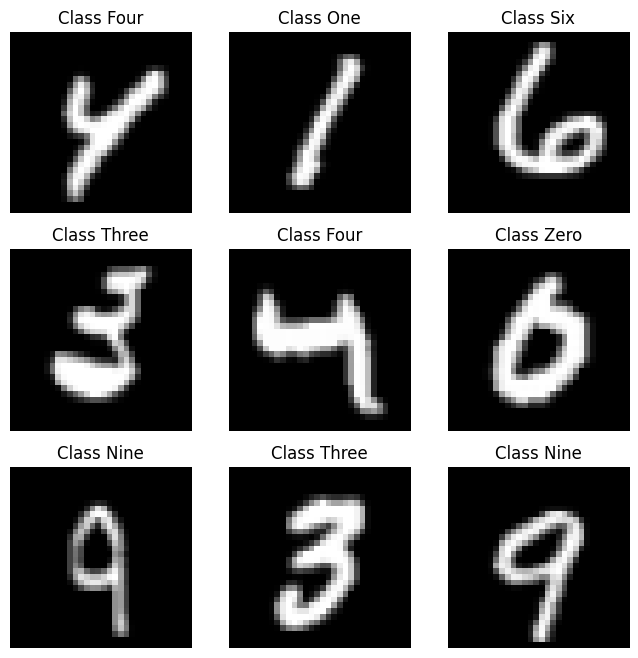

Training Epochs:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ahidv\AppData\Roaming\Python\Python311\site-packages\torch\nn\functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Training Epochs: 100%|██████████| 1/1 [00:14<00:00, 14.59s/it]


Trained the model in 14.59 seconds


Model Accuracy: 97.92%
Learning rate was: 0.01
Number of epochs was: 1
Tested the model in 2.137 seconds




Training Epochs: 100%|██████████| 3/3 [00:41<00:00, 13.94s/it]


Trained the model in 41.84 seconds


Model Accuracy: 98.12%
Learning rate was: 0.01
Number of epochs was: 3
Tested the model in 2.034 seconds




Training Epochs: 100%|██████████| 5/5 [01:11<00:00, 14.29s/it]


Trained the model in 71.46 seconds


Model Accuracy: 98.50%
Learning rate was: 0.01
Number of epochs was: 5
Tested the model in 2.047 seconds




Training Epochs: 100%|██████████| 1/1 [00:14<00:00, 14.27s/it]


Trained the model in 14.28 seconds


Model Accuracy: 97.73%
Learning rate was: 0.005
Number of epochs was: 1
Tested the model in 2.008 seconds




Training Epochs: 100%|██████████| 3/3 [00:42<00:00, 14.13s/it]


Trained the model in 42.41 seconds


Model Accuracy: 98.58%
Learning rate was: 0.005
Number of epochs was: 3
Tested the model in 2.117 seconds




Training Epochs: 100%|██████████| 5/5 [01:11<00:00, 14.21s/it]


Trained the model in 71.07 seconds


Model Accuracy: 98.91%
Learning rate was: 0.005
Number of epochs was: 5
Tested the model in 2.181 seconds




Training Epochs: 100%|██████████| 1/1 [00:14<00:00, 14.39s/it]


Trained the model in 14.39 seconds


Model Accuracy: 95.62%
Learning rate was: 0.001
Number of epochs was: 1
Tested the model in 2.058 seconds




Training Epochs: 100%|██████████| 3/3 [00:43<00:00, 14.51s/it]


Trained the model in 43.54 seconds


Model Accuracy: 98.23%
Learning rate was: 0.001
Number of epochs was: 3
Tested the model in 2.085 seconds




Training Epochs: 100%|██████████| 5/5 [01:12<00:00, 14.58s/it]


Trained the model in 72.92 seconds


Model Accuracy: 98.78%
Learning rate was: 0.001
Number of epochs was: 5
Tested the model in 2.094 seconds


Maximum accuracy achieved for dataset MNIST: 98.78%
Learning rate for the higehst accuracy: 0.001
Number of epochs for the highest accuracy: 5
Loading best model...


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 12, 12]             880
         Dropout2d-3             [-1, 16, 6, 6]               0
            Linear-4                  [-1, 120]          69,240
            Linear-5                   [-1, 84]          10,164
         Dropout2d-6                   [-1, 84]               0
            Linear-7                   [-1, 10]             850
Total params: 81,290
Trainable params: 81,290
Non-trainable params: 0
-----------------------------------------

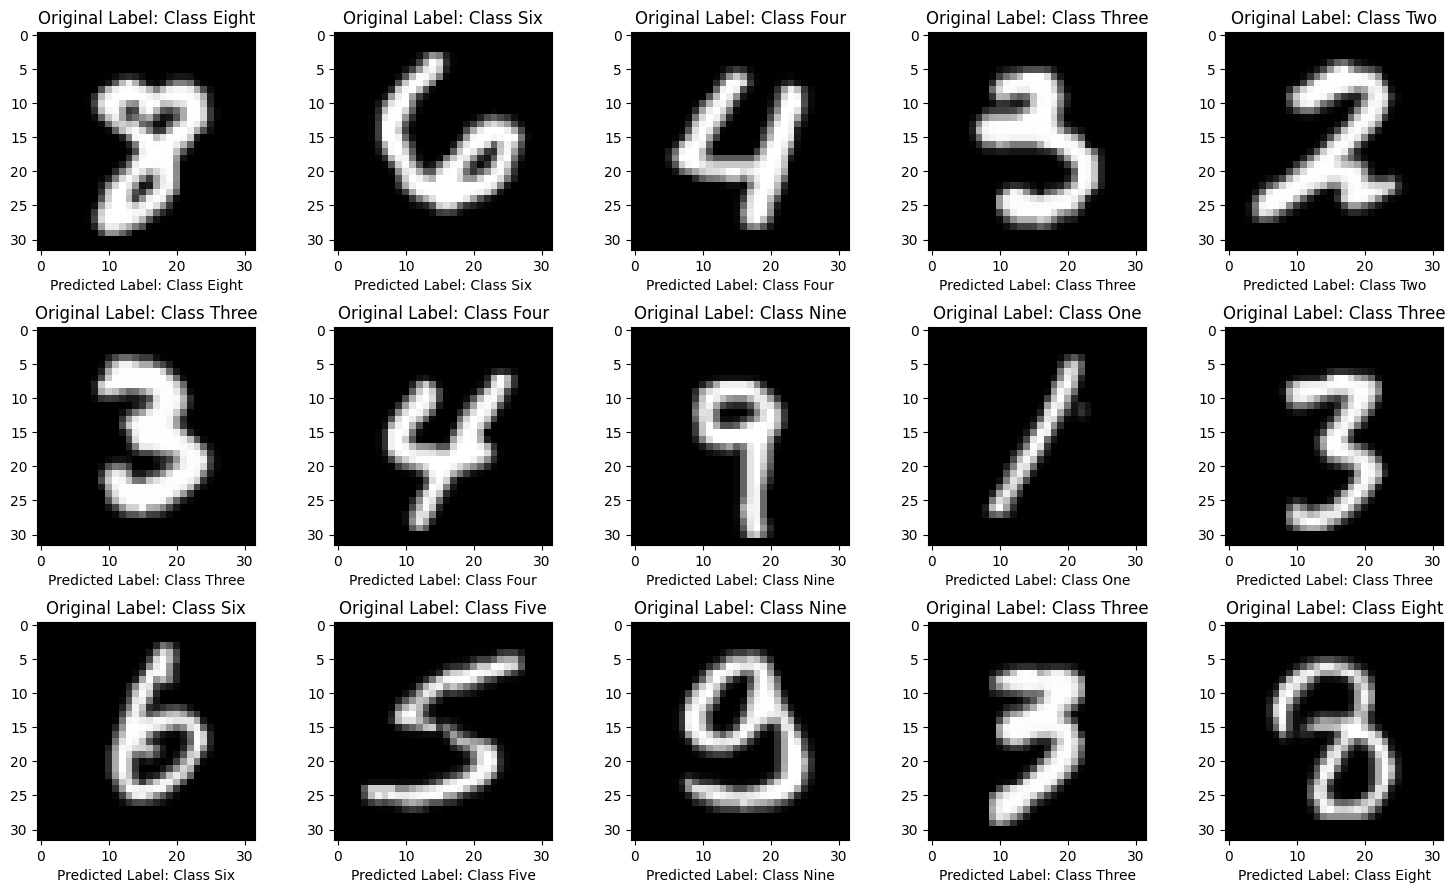

Classification made in 1.354 seconds
Done with dataset MNIST!


Starting with dataset FashionMNIST!
Feature batch shape: torch.Size([250, 1, 32, 32])
Labels batch shape: torch.Size([250])


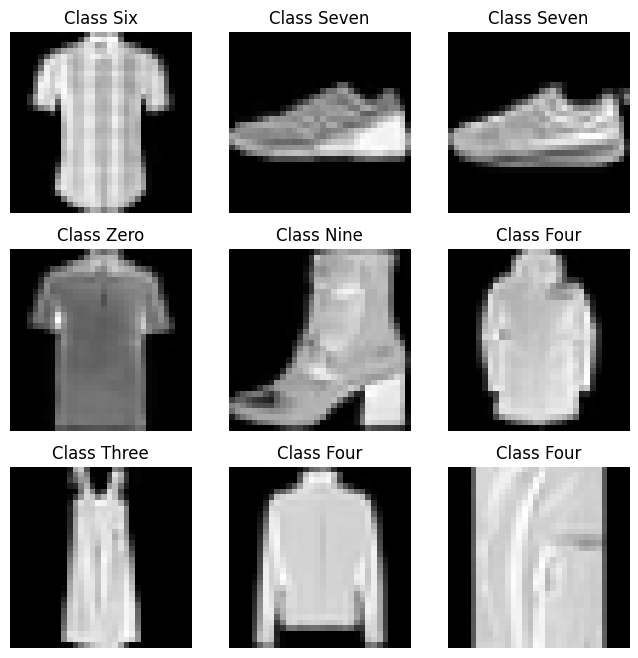

Training Epochs: 100%|██████████| 1/1 [00:15<00:00, 15.16s/it]


Trained the model in 15.16 seconds


Model Accuracy: 81.86%
Learning rate was: 0.01
Number of epochs was: 1
Tested the model in 2.103 seconds




Training Epochs: 100%|██████████| 3/3 [00:48<00:00, 16.10s/it]


Trained the model in 48.31 seconds


Model Accuracy: 88.01%
Learning rate was: 0.01
Number of epochs was: 3
Tested the model in 2.618 seconds




Training Epochs: 100%|██████████| 5/5 [01:31<00:00, 18.40s/it]


Trained the model in 92.02 seconds


Model Accuracy: 88.26%
Learning rate was: 0.01
Number of epochs was: 5
Tested the model in 2.63 seconds




Training Epochs: 100%|██████████| 1/1 [00:16<00:00, 16.12s/it]


Trained the model in 16.12 seconds


Model Accuracy: 80.46%
Learning rate was: 0.005
Number of epochs was: 1
Tested the model in 2.154 seconds




Training Epochs: 100%|██████████| 3/3 [00:44<00:00, 14.72s/it]


Trained the model in 44.17 seconds


Model Accuracy: 87.43%
Learning rate was: 0.005
Number of epochs was: 3
Tested the model in 2.095 seconds




Training Epochs: 100%|██████████| 5/5 [01:11<00:00, 14.37s/it]


Trained the model in 71.85 seconds


Model Accuracy: 89.08%
Learning rate was: 0.005
Number of epochs was: 5
Tested the model in 2.159 seconds




Training Epochs: 100%|██████████| 1/1 [00:14<00:00, 14.50s/it]


Trained the model in 14.5 seconds


Model Accuracy: 77.97%
Learning rate was: 0.001
Number of epochs was: 1
Tested the model in 2.125 seconds




Training Epochs: 100%|██████████| 3/3 [00:42<00:00, 14.15s/it]


Trained the model in 42.45 seconds


Model Accuracy: 84.53%
Learning rate was: 0.001
Number of epochs was: 3
Tested the model in 2.077 seconds




Training Epochs: 100%|██████████| 5/5 [01:10<00:00, 14.03s/it]


Trained the model in 70.17 seconds


Model Accuracy: 87.50%
Learning rate was: 0.001
Number of epochs was: 5
Tested the model in 2.094 seconds


Maximum accuracy achieved for dataset FashionMNIST: 87.50%
Learning rate for the higehst accuracy: 0.001
Number of epochs for the highest accuracy: 5
Loading best model...


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 12, 12]             880
         Dropout2d-3             [-1, 16, 6, 6]               0
            Linear-4                  [-1, 120]          69,240
            Linear-5                   [-1, 84]          10,164
         Dropout2d-6                   [-1, 84]               0
            Linear-7                   [-1, 10]             850
Total params: 81,290
Trainable params: 81,290
Non-trainable params: 0
----------------------------------

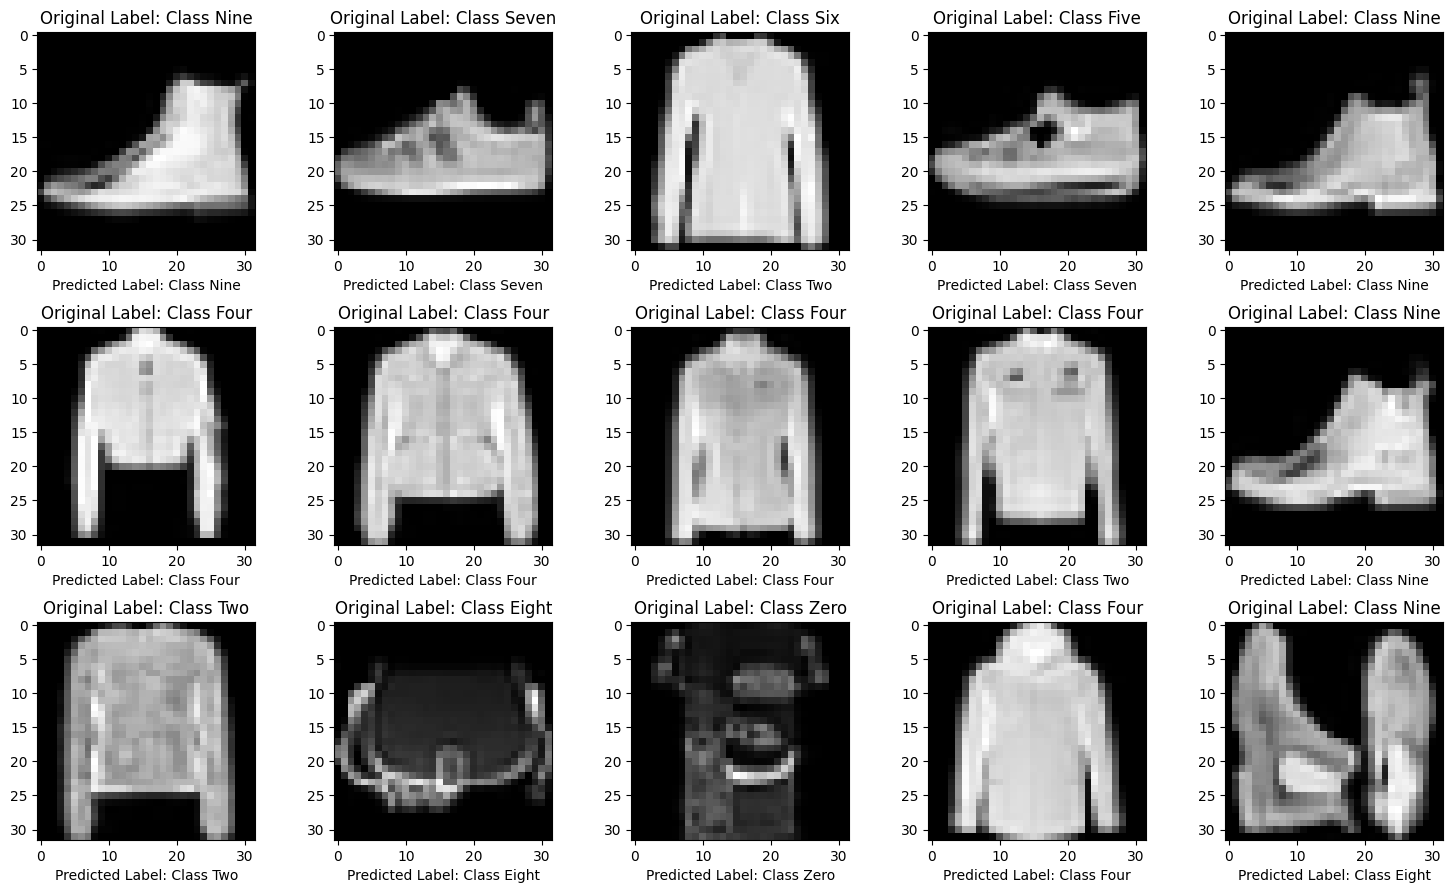

Classification made in 1.178 seconds
Done with dataset FashionMNIST!


Starting with dataset CIFAR10!
Files already downloaded and verified
Files already downloaded and verified
Feature batch shape: torch.Size([250, 3, 32, 32])
Labels batch shape: torch.Size([250])


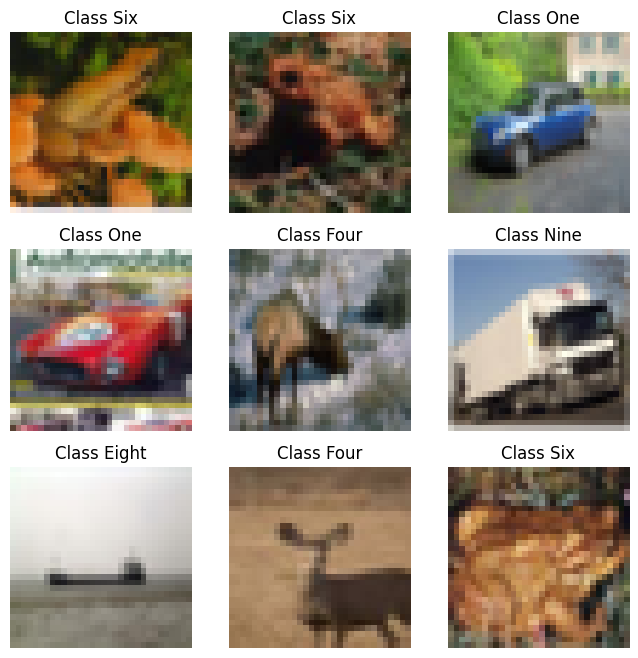

Training Epochs: 100%|██████████| 1/1 [00:10<00:00, 10.66s/it]


Trained the model in 10.67 seconds


Model Accuracy: 30.78%
Learning rate was: 0.01
Number of epochs was: 1
Tested the model in 1.877 seconds




Training Epochs: 100%|██████████| 3/3 [00:32<00:00, 10.83s/it]


Trained the model in 32.49 seconds


Model Accuracy: 38.08%
Learning rate was: 0.01
Number of epochs was: 3
Tested the model in 1.996 seconds




Training Epochs: 100%|██████████| 5/5 [00:52<00:00, 10.60s/it]


Trained the model in 53.01 seconds


Model Accuracy: 42.98%
Learning rate was: 0.01
Number of epochs was: 5
Tested the model in 1.897 seconds




Training Epochs: 100%|██████████| 1/1 [00:10<00:00, 10.83s/it]


Trained the model in 10.83 seconds


Model Accuracy: 40.22%
Learning rate was: 0.005
Number of epochs was: 1
Tested the model in 1.879 seconds




Training Epochs: 100%|██████████| 3/3 [00:31<00:00, 10.47s/it]


Trained the model in 31.41 seconds


Model Accuracy: 49.69%
Learning rate was: 0.005
Number of epochs was: 3
Tested the model in 1.903 seconds




Training Epochs: 100%|██████████| 5/5 [00:51<00:00, 10.38s/it]


Trained the model in 51.9 seconds


Model Accuracy: 54.31%
Learning rate was: 0.005
Number of epochs was: 5
Tested the model in 1.845 seconds




Training Epochs: 100%|██████████| 1/1 [00:10<00:00, 10.74s/it]


Trained the model in 10.74 seconds


Model Accuracy: 39.35%
Learning rate was: 0.001
Number of epochs was: 1
Tested the model in 1.903 seconds




Training Epochs: 100%|██████████| 3/3 [00:32<00:00, 10.79s/it]


Trained the model in 32.38 seconds


Model Accuracy: 48.35%
Learning rate was: 0.001
Number of epochs was: 3
Tested the model in 1.87 seconds




Training Epochs: 100%|██████████| 5/5 [00:53<00:00, 10.62s/it]


Trained the model in 53.12 seconds


Model Accuracy: 55.77%
Learning rate was: 0.001
Number of epochs was: 5
Tested the model in 1.883 seconds


Maximum accuracy achieved for dataset CIFAR10: 55.77%
Learning rate for the higehst accuracy: 0.001
Number of epochs for the highest accuracy: 5
Loading best model...


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
            Conv2d-2           [-1, 16, 12, 12]             880
         Dropout2d-3             [-1, 16, 6, 6]               0
            Linear-4                  [-1, 120]          69,240
            Linear-5                   [-1, 84]          10,164
         Dropout2d-6                   [-1, 84]               0
            Linear-7                   [-1, 10]             850
Total params: 81,590
Trainable params: 81,590
Non-trainable params: 0
---------------------------------------

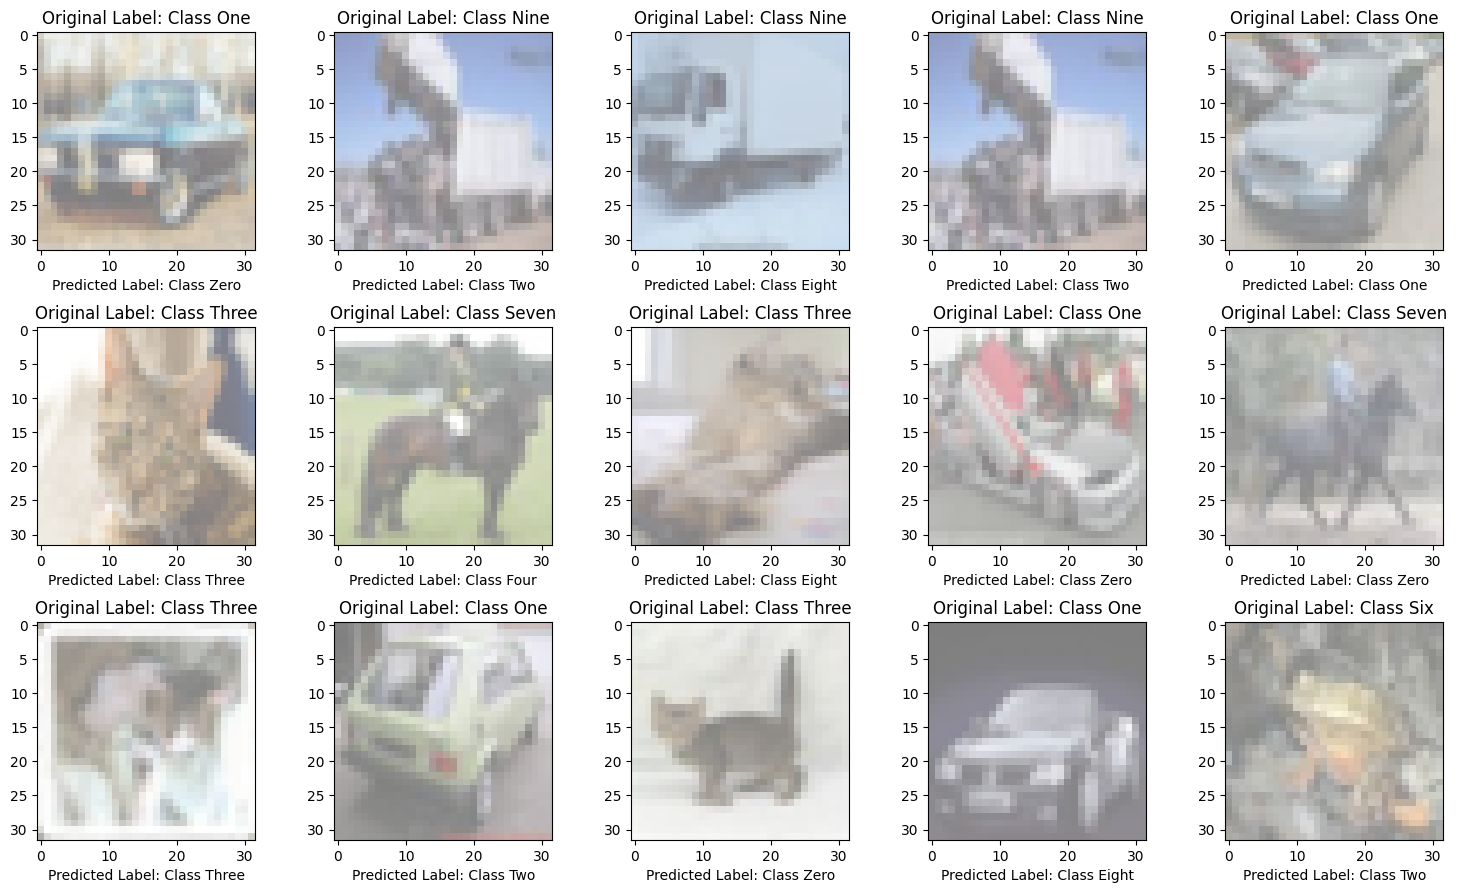

Classification made in 1.37 seconds
Done with dataset CIFAR10!




In [37]:
#E2E for the "project"
# Train the model
for i in range(len(data)):
    print(f"Starting with dataset {data[i].__name__}!")
    train_data = data[i](root= loc, train= True, transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((input_size, input_size)),transforms.Normalize((0,), (1,))]), download=True)
    test_data = data[i](root=loc, train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((input_size, input_size)),transforms.Normalize((0,), (1,))]), download=True)

    train_loader =  DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    # Visualize the data
    labels_map = {
        0: "Class Zero",
        1: "Class One",
        2: "Class Two",
        3: "Class Three",
        4: "Class Four",
        5: "Class Five",
        6: "Class Six",
        7: "Class Seven",
        8: "Class Eight",
        9: "Class Nine",
    }

    train_features, train_labels = next(iter(train_loader))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")

    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for k in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(train_data), size=(1,)).item()
        img, label = train_data[sample_idx]
        figure.add_subplot(rows, cols, k)
        if train_features.size()[1] == 3:
            dataiter = iter(train_loader)
            images, labels = next(dataiter)
            plt.imshow(transforms.ToPILImage()(img))
            plt.title(labels_map[label])
            plt.axis("off")
        else:
            plt.title(labels_map[label])
            plt.axis("off")
            plt.imshow(img.squeeze(), cmap="gray")
    plt.show()
        
    # Initialize the Model, Optimizer and Loss function
    for p in range(len(lr_list)):
        accs = []
        best_round = 0
        model = CNN()
        optimizer = optim.Adam(model.parameters(), lr=lr_list[p])
        loss_function = nn.CrossEntropyLoss()

        for pp in range(len(epoch_list)):
            # Train the model
            tic = time.perf_counter()
            train_model(model, train_loader, loss_function, optimizer, epochs = epoch_list[pp])
            toc = time.perf_counter()
            print(f"Trained the model in {toc - tic:0.4} seconds")

            # Test the model
            tic = time.perf_counter()
            cnn_accuracy = test_model(model, test_loader)
            print(f"Model Accuracy: {cnn_accuracy*100:.2f}%")
            toc = time.perf_counter()
            print(f"Learning rate was: {lr_list[p]}")
            print(f"Number of epochs was: {epoch_list[pp]}")  
            print(f"Tested the model in {toc - tic:0.4} seconds")
            accs.append(cnn_accuracy)
            print("\n")
        
            # Save the model
            torch.save(model.state_dict(), r'C:\Users\ahidv\OneDrive\Desktop\models_improv/' + data[i].__name__ + '_epochs_' + str(epoch_list[pp]) + '_lr_' + str(lr_list[p]) + '_conv.pth')
            #print(model.parameters)
            #print("Model saved!")
            #print("\n")

            # Save the best accuracy
            if cnn_accuracy >= max(accs):
                best_round = (lr_list[p], epoch_list[pp])

            # if the last epoch was evaluated, summarize the findings
            if p == (len(lr_list)-1) and pp == (len(epoch_list)-1):
                print(f"Maximum accuracy achieved for dataset {data[i].__name__}: {max(accs)*100:.2f}%")
                print(f"Learning rate for the higehst accuracy: {best_round[0]}")
                print(f"Number of epochs for the highest accuracy: {best_round[1]}")   
                print("Loading best model...")
                print("\n")
                model = CNN()
                model.load_state_dict(torch.load('C:/Users/ahidv/OneDrive/Desktop/models_improv/' + data[i].__name__ + '_epochs_' + str(best_round[1]) + '_lr_' + str(best_round[0]) + '_conv.pth'))
                model.eval()
                summary(model, input_size=(train_features.size()[1], input_size, input_size))

                # Save the best model and remove the others
                best_model_folder = 'C:/Users/ahidv/OneDrive/Desktop/best_models/'

                if not os.path.exists(best_model_folder):
                        try:
                            os.makedirs(best_model_folder)
                            print(f"Folder '{best_model_folder}' created successfully.")
                            print("\n")
                        except OSError as e:
                            print(f"Error creating folder '{best_model_folder}': {e}")
                            print("\n")
                else:
                    print("\n")

                shutil.move('C:/Users/ahidv/OneDrive/Desktop/models_improv/' + data[i].__name__ + '_epochs_' + str(best_round[1]) + '_lr_' + str(best_round[0]) + '_conv.pth', 'C:/Users/ahidv/OneDrive/Desktop/best_models/' + data[i].__name__ + '_epochs_' + str(best_round[1]) + '_lr_' + str(best_round[0]) + '_conv.pth')

                files = os.listdir('C:/Users/ahidv/OneDrive/Desktop/models_improv/')
                models_folder = "C:/Users/ahidv/OneDrive/Desktop/models_improv/"

                for zz in range(len(files)):
                    os.remove(models_folder+files[zz])

                # Make prediction with the best model
                rows = 3
                cols = 5
                tic = time.perf_counter()
                display_prediction(model, test_data, rows, cols)
                toc = time.perf_counter()
                print(f"Classification made in {toc - tic:0.4} seconds")
                print(f"Done with dataset {data[i].__name__}!")
                print("\n")

                #Check how the models are saved, some looping is shit
                # Can we maybe, train -> save the model -> print the info if the necessary epoch is hit --> reload the model --> further train...

 




## Conclusion of both tasks

While each model demonstrates high proficiency in its respective task, direct comparisons across these tasks should be approached with caution. The CNN's performance on MNIST highlights its strength in handling complex, high-dimensional image data. Conversely, MLP and SVM show versatility and effectiveness on simpler, structured datasets like Iris and Wine. The key takeaway is the importance of choosing the right model for the specific characteristics and requirements of the dataset at hand.  
  
Different architectures yield different results, therefore it's important to give deep considerations when selecting the architecture for the task at hand. The above small example in task 2 also shows the importance of identifying and tuning of the hyperparameters for better results.